In [1]:
print("Test")

Test


In [2]:
import pandas as pd

data = {
    'ID': range(0,10),
    'Name': ['Test1','Test2','Test3','Test4','Test5','Test6','Test7','Test8','Test9','Test10'],
    'Zahl': [32,34,7,4,34,2,11,9,3,36]
}

df = pd.DataFrame(data)

df

,ID,Name,Zahl
0,0,Test1,32
1,1,Test2,34
2,2,Test3,7
3,3,Test4,4
4,4,Test5,34
5,5,Test6,2
6,6,Test7,11
7,7,Test8,9
8,8,Test9,3
9,9,Test10,36


In [3]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = TimeSeriesDataFrame.from_path(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/australian_electricity_subset/test.csv"
)
data.head()

target
item_id timestamp                       
T000000 2013-03-10 00:00:00  5207.959961
        2013-03-10 00:30:00  5002.275879
        2013-03-10 01:00:00  4747.569824
        2013-03-10 01:30:00  4544.880859
        2013-03-10 02:00:00  4425.952148

In [5]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_small",
)

Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250509_103205'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.40 GB / 15.70 GB (2.6%)
Disk Space Avail:   79.94 GB / 475.50 GB (16.8%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series freque

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]


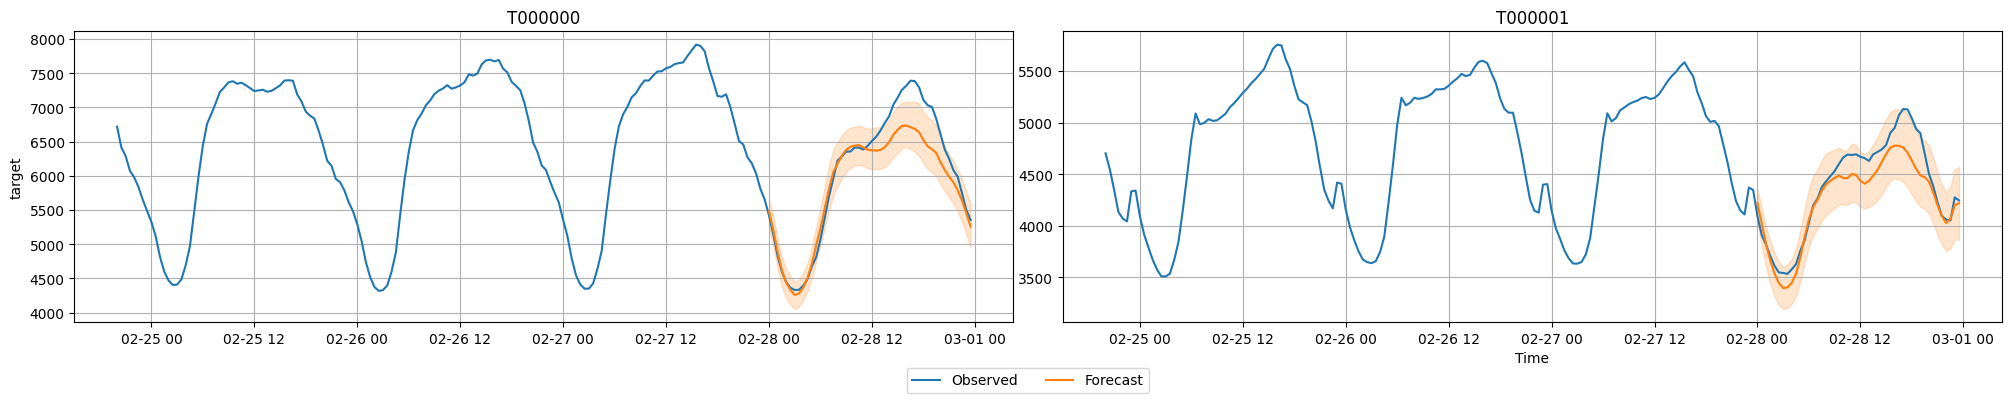

In [6]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);

# Fine-Tuning

In [7]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data=train_data,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250509_103757'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.88 GB / 15.70 GB (5.6%)
Disk Space Avail:   79.76 GB / 475.50 GB (16.8%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'},
                                 {'ag_args': {'name_suffix': 'FineTuned'},
                                  'fine_tune': True,
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,

In [9]:
predictor.leaderboard(test_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(
c:\workspace\CrimeMap\CrimeMap_venv\Lib\site-packages\autogluon\timeseries\metrics\abstract.py:101: FutureWarning: Passing `prediction_length` to `TimeSeriesScorer.__call__` is deprecated and will be removed in v2.0. Please set the `eval_metric.prediction_length` attribute instead.
  warnings.warn(


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.040169,-0.039707,0.488883,0.502086,51.989371,2
1,ChronosZeroShot[bolt_small],-0.041446,-0.041720,1.927625,1.198816,0.147036,1
